In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers import add

In [2]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions
    

In [3]:
captions  = readTextFile(r"give path of captions.txt file of your dataset to train the model ")
captions = captions.split('\n')[:-1]

In [4]:
print(len(captions))

40455


In [5]:
# Split the first caption by comma
first, second = captions[0].split(',')

# Print the first part
print(first.split(".")[0])

# Print the second part
print(second)


1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [6]:
descriptions = {}

for caption in captions:
    # Split each line into filename and caption
    filename, caption = caption.split(',', 1)  # Split only at the first comma
    
    # Extract image name without extension
    img_name = filename.split(".")[0]
    
    # If the image id is not already present, create an empty list
    if img_name not in descriptions:
        descriptions[img_name] = []
    
    # Append the caption to the list of descriptions for the image
    descriptions[img_name].append(caption.strip())  # Remove leading/trailing whitespaces

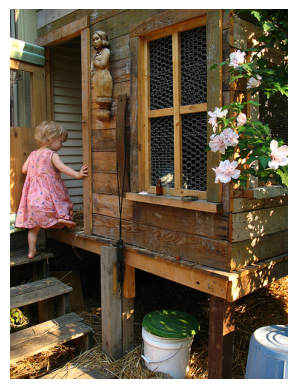

In [7]:
import os
IMG_PATH = r"give path of Images.jpg file of your dataset to train the model"
import cv2
import matplotlib.pyplot as plt

# Read the image from the path
img = cv2.imread(os.path.join(IMG_PATH, "1000268201_693b08cb0e.jpg"))

# Check if the image is loaded successfully
if img is None:
    print("Image not found or invalid format")
else:
    # Convert the color of the image
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(img)
    plt.axis("off")
    plt.show()


In [8]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [9]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [10]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [11]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [12]:
# Write the data to text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

In [13]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [14]:
print(type(descriptions))

<class 'dict'>


In [15]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [16]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 373803


In [17]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [18]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [19]:
print(len(total_words))

1845


In [20]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths for the original image folder, captions file, and test folders
original_images_folder = r"give path of Images file of your dataset to train the model"
original_captions_file = r"give path of captions.txt file of your dataset to train the model"
test_images_folder = r"give path of imgs file to store 20% of images of dataset to test the model"
test_captions_file = r"give path of caps.txt file to store 20% of captions of dataset to test the model"

# Read the image filenames and captions from the original dataset
with open(original_captions_file, 'r') as file:
    captions_data = file.readlines()

image_filenames = [line.split(',')[0] for line in captions_data]

# Split the data into training and testing sets
train_image_filenames, test_image_filenames = train_test_split(image_filenames, test_size=0.2, random_state=42)

# Create the test folder if it doesn't exist
os.makedirs(test_images_folder, exist_ok=True)

# Move the testing images to the test folder and write test captions to the test captions file
with open(test_captions_file, 'w') as test_file:
    for img_filename in test_image_filenames:
        img_path = os.path.join(original_images_folder, img_filename)
        shutil.copy(img_path, os.path.join(test_images_folder, img_filename + ".jpg"))
        
        # Write the corresponding captions to the test captions file
        img_captions = [line for line in captions_data if line.startswith(img_filename)]
        test_file.writelines(img_captions)

print("Testing data saved successfully.")


Testing data saved successfully.


In [20]:
train_file_data = readTextFile(r"give path of captions.txt file of your dataset to train the model")
test_file_data = readTextFile(r"give path of caps.txt file of your dataset to test the model")

In [21]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [22]:
train[:5]

['1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e']

In [23]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [24]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [25]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [26]:
#take the inut and return the second last layer i.e., to take encondings only and not to take 1000 classes
model_new = Model(model.input,model.layers[-2].output)

In [27]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img


In [28]:
#img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
#plt.imshow(img[0])
#plt.axis("off")
#plt.show()

In [29]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [31]:
from PIL import Image

# Import the load_img and img_to_array functions from tensorflow.keras.utils
# import keras.utils as image
from tensorflow.keras.preprocessing import image as keras_image
import io

# Load the image using the load_img function
img = keras_image.load_img(IMG_PATH + "1000268201_693b08cb0e.jpg", target_size=(224, 224))

# Convert the image to an array using the img_to_array function
img_array = keras_image.img_to_array(img)

# Convert the NumPy array to a PIL Image
pil_image = Image.fromarray(img_array.astype('uint8'))

# Save the PIL Image to the BytesIO object
img_bytes_io = io.BytesIO()
pil_image.save(img_bytes_io, format='JPEG')

# Encode the image using your custom function
encode_image(img_bytes_io)


1/1 [==============================] - 4s 4s/step


array([0.01608639, 0.20953138, 0.19926174, ..., 0.02512329, 0.3293863 ,
       0.6146404 ], dtype=float32)

In [32]:
import os
from time import time
from keras import backend as K

# Replace 'images' with the actual path to your image directory
image_directory = r"give path of Images file of your dataset to train the model"

# Get all files in the directory
image_files = os.listdir(image_directory)

# Extract image IDs from the file names
train = [file.split(".")[0] for file in image_files]

# Take the first 8000 image IDs
train_subset = train[:8000]

batch_size = 5  # Adjust the batch size as needed
num_batches = len(train_subset) // batch_size

start = time()
encoding_train = {}

for batch_num in range(num_batches):
    start_idx = batch_num * batch_size
    end_idx = (batch_num + 1) * batch_size
    batch_ids = train_subset[start_idx:end_idx]

    for ix, img_id in enumerate(batch_ids):
        img_path = os.path.join(image_directory, img_id + ".jpg")
        encoding_train[img_id] = encode_image(img_path)

        if ix % 100 == 0:
            print("Encoding in Progress - Batch %d, Step %d" % (batch_num, ix))

    # Clear memory
    K.clear_session()

# Process the remaining images (if any)
remaining_ids = train_subset[num_batches * batch_size:]
for ix, img_id in enumerate(remaining_ids):
    img_path = os.path.join(image_directory, img_id + ".jpg")
    encoding_train[img_id] = encode_image(img_path)

    if ix % 100 == 0:
        print("Encoding in Progress - Batch %d, Step %d" % (num_batches, ix))

    # Clear memory
    K.clear_session()

end_t = time()
print("Total Time Taken:", end_t - start)

1/1 [==============================] - 0s 366ms/step
Encoding in Progress - Batch 0, Step 0
1/1 [==============================] - 1s 1s/step
Encoding in Progress - Batch 1, Step 0
1/1 [==============================] - 1s 1s/step
Encoding in Progress - Batch 2, Step 0
1/1 [==============================] - 2s 2s/step
Encoding in Progress - Batch 3, Step 0
1/1 [==============================] - 2s 2s/step
Encoding in Progress - Batch 4, Step 0
1/1 [==============================] - 2s 2s/step
Encoding in Progress - Batch 5, Step 0
1/1 [==============================] - 2s 2s/step
Encoding in Progress - Batch 6, Step 0
1/1 [==============================] - 2s 2s/step
Encoding in Progress - Batch 7, Step 0
1/1 [==============================] - 1s 1s/step
Encoding in Progress - Batch 8, Step 0
1/1 [==============================] - 2s 2s/step
Encoding in Progress - Batch 9, Step 0
1/1 [==============================] - 1s 1s/step
Encoding in Progress - Batch 10, Step 0
1/1 [============

In [33]:
!mkdir saved

A subdirectory or file saved already exists.


In [34]:
# Store everything to the disk 
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [35]:
# start = time()
# encoding_test = {}
# #image_id -->feature_vector extracted from Resnet Image

# for ix,img_id in enumerate(test):
#     img_path = IMG_PATH+"/"+img_id+".jpg"
#     encoding_test[img_id] = encode_image(img_path)
    
#     if ix%100==0:
#         print("Test Encoding in Progress Time step %d "%ix)
        
# end_t = time()
# print("Total Time Taken(test) :",end_t-start)
from time import time
import os
import keras.backend as K

# List image files in the test directory
test_image_folder = r"give path of imgs file of your dataset to test the model"
test_image_filenames = os.listdir(test_image_folder)

start = time()
encoding_test = {}

# Adjust batch size as needed
batch_size = 5

# Get the number of batches
num_batches = len(test_image_filenames) // batch_size

for batch_num in range(num_batches):
    start_idx = batch_num * batch_size
    end_idx = (batch_num + 1) * batch_size
    batch_ids = test_image_filenames[start_idx:end_idx]

    for ix, img_filename in enumerate(batch_ids):
        img_path = os.path.join(test_image_folder, img_filename)
        encoding_test[img_filename.split(".")[0]] = encode_image(img_path)

        if ix % 100 == 0:
            print("Test Encoding in Progress - Batch %d, Step %d" % (batch_num, ix))

    # Clear memory after each batch
    K.clear_session()

# Process the remaining images (if any)
remaining_ids = test_image_filenames[num_batches * batch_size:]
for ix, img_filename in enumerate(remaining_ids):
    img_path = os.path.join(test_image_folder, img_filename)
    encoding_test[img_filename.split(".")[0]] = encode_image(img_path)

    if ix % 100 == 0:
        print("Test Encoding in Progress - Batch %d, Step %d" % (num_batches, ix))

    # Clear memory
    K.clear_session()

end_t = time()
print("Total Time Taken(test) :", end_t - start)

1/1 [==============================] - 1s 536ms/step
Test Encoding in Progress - Batch 0, Step 0
1/1 [==============================] - 1s 697ms/step
Test Encoding in Progress - Batch 1, Step 0
1/1 [==============================] - 1s 765ms/step
Test Encoding in Progress - Batch 2, Step 0
1/1 [==============================] - 1s 663ms/step
Test Encoding in Progress - Batch 3, Step 0
1/1 [==============================] - 1s 664ms/step
Test Encoding in Progress - Batch 4, Step 0
1/1 [==============================] - 1s 670ms/step
Test Encoding in Progress - Batch 5, Step 0
1/1 [==============================] - 1s 829ms/step
Test Encoding in Progress - Batch 6, Step 0
1/1 [==============================] - 1s 696ms/step
Test Encoding in Progress - Batch 7, Step 0
1/1 [==============================] - 1s 793ms/step
Test Encoding in Progress - Batch 8, Step 0
1/1 [==============================] - 1s 1s/step
Test Encoding in Progress - Batch 9, Step 0
1/1 [============================

In [36]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [37]:
# Vocab
len(total_words)

1845

In [38]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [39]:
#word_to_idx["dog"]
#idx_to_word[1]
print(len(idx_to_word))

1845


In [40]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [41]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


In [107]:
##################Add these dictonaires
import pickle

with open(r"give path of word to index file of your dictionary", "wb") as w2i:
    pickle.dump(word_to_idx, w2i)

with open(r"give path of index to word file of your dictionary", "wb") as i2w:
    pickle.dump(idx_to_word, i2w)


In [42]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorcial([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [43]:
f = open(r"give path of glove dictionary file of your dataset to train the model",encoding='utf8')

In [44]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [45]:
f.close()

In [46]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [47]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [48]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [49]:
#embedding_matrix[1847]

In [50]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [51]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [52]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [53]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                                                              

In [54]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [55]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [56]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [57]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [58]:
model.save(r'save the trained model weights at your desired location')

In [95]:
model = load_model(r"load the weights of trained model from the save location ")

In [100]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #Word with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break

    final_caption = in_text.split()[1:-1]
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

1/1 [==============================] - 0s 43ms/step


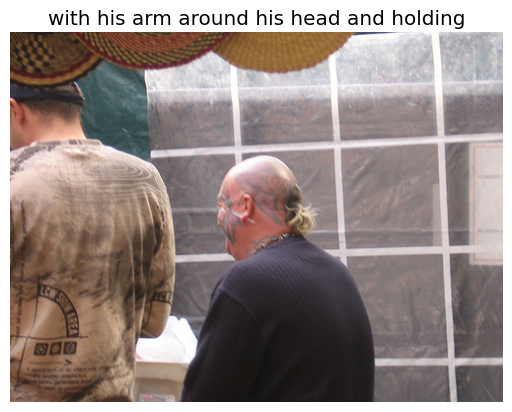

1/1 [==============================] - 0s 44ms/step


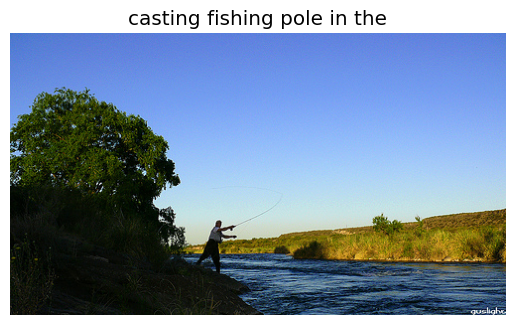

1/1 [==============================] - 0s 109ms/step


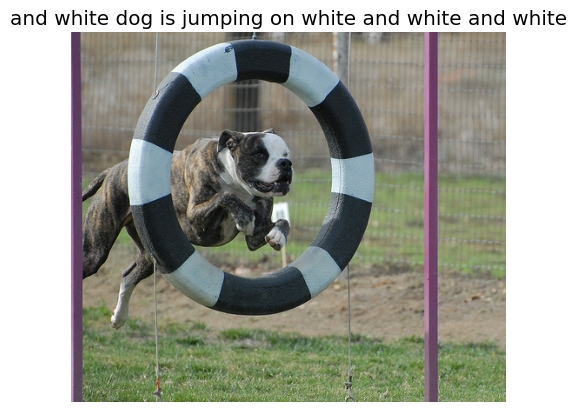

1/1 [==============================] - 0s 86ms/step


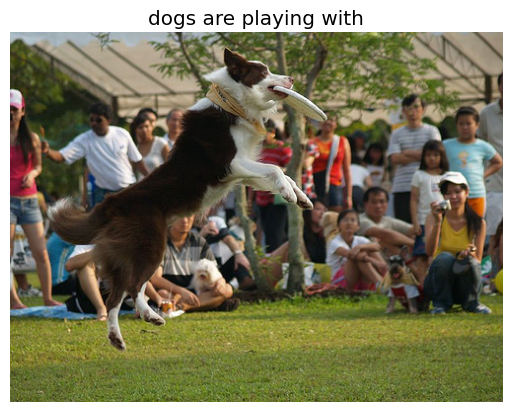

1/1 [==============================] - 0s 65ms/step


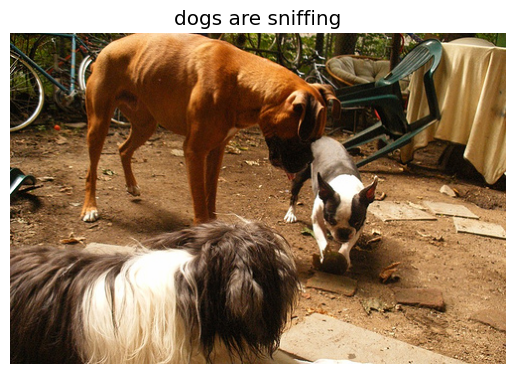

In [102]:
# Pick Some Random Images and See Results
plt.style.use("ggplot")
for i in range(5):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    
    img_path = os.path.join(r"give path of Images file of your dataset ", img_name + ".jpg")

    i = plt.imread(img_path)

    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()